In [1]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import ListedColormap
import pandas as pd
import json

import hdbscan
from umap import UMAP
from mpl_toolkits.mplot3d import Axes3D

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

from scipy.spatial.distance import pdist, squareform
#%matplotlib widget

In [2]:
n_clusters = 20
name_extension = "graph_vae_v3"

In [3]:
# Generate a more readable colormap for 3D plots
colors = plt.cm.hsv(np.linspace(0, 1, n_clusters))
custom_cmap = ListedColormap(colors)

# Generate a more readable colormap for 2D plots
colors_2D = custom_cmap.colors if hasattr(custom_cmap, "colors") else plt.cm.hsv(np.linspace(0, 1, n_clusters))

In [4]:
# Load embeddings and correspondance
embeddings = np.load("embeddings/mu_{}.npy".format(name_extension), allow_pickle=True)
path = f"embeddings/correspondence_{name_extension}.json"  # note: JSON
with open(path, "r") as f:
    correspondence = json.load(f)

In [5]:
#We select the mean embeddings
mu_embeddings = embeddings
print(mu_embeddings.shape)

(49125, 128)


In [6]:
#Before doing anything, as we are going to use KMeans or UMAP, we need to scale the data

#We normalize the data
scaler = StandardScaler()
mu_embeddings_normalized = scaler.fit_transform(mu_embeddings)

In [7]:
#We check some things in the following cells
mu_embeddings[0]

array([2.24214569e-02, 1.31181274e-02, 8.95257890e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 9.02207394e-05, 6.85128421e-02,
       4.49063033e-02, 9.52845160e-03, 1.26832621e-02, 1.03424676e-02,
       0.00000000e+00, 0.00000000e+00, 8.59080232e-04, 0.00000000e+00,
       1.82893348e-03, 9.88850519e-02, 5.12097904e-04, 4.27737227e-03,
       4.74396348e-02, 0.00000000e+00, 2.33035395e-03, 4.11129849e-06,
       2.71072723e-02, 3.97480391e-02, 6.13666661e-02, 0.00000000e+00,
       1.35274575e-04, 4.12075669e-02, 9.46349278e-03, 2.87328884e-02,
       4.97851148e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.72695588e-02, 5.66458702e-03, 2.08124314e-02, 0.00000000e+00,
       1.44749321e-02, 1.93423852e-02, 5.59705913e-05, 5.13694696e-02,
       4.98070270e-02, 6.72189891e-02, 4.48687002e-03, 2.13147439e-02,
       4.81800959e-02, 6.95380196e-02, 7.20846951e-02, 2.35451479e-02,
       2.85450947e-02, 0.00000000e+00, 2.07859781e-02, 3.80375460e-02,
      

In [8]:
mu_embeddings_normalized.std(axis=0).size

128

In [9]:
mu_embeddings_normalized_store_to_test_in_the_end = mu_embeddings_normalized.copy()

In [10]:
mu_embeddings.mean(axis=0), mu_embeddings_normalized.mean(axis=0), mu_embeddings_normalized.std(axis=0)

(array([3.6375638e-02, 3.2210238e-02, 1.0540568e-01, 2.6060883e-07,
        6.4157553e-07, 1.4059845e-05, 1.5880751e-04, 8.2705006e-02,
        5.5777777e-02, 1.3453196e-02, 2.9312370e-02, 2.1838291e-02,
        5.1821433e-05, 0.0000000e+00, 1.4348268e-03, 0.0000000e+00,
        4.5273663e-03, 1.2848434e-01, 7.9045846e-04, 7.5732907e-03,
        5.5188812e-02, 6.0001767e-04, 1.0745597e-02, 1.3815105e-04,
        3.2964613e-02, 4.0844813e-02, 5.6778528e-02, 0.0000000e+00,
        3.0253347e-04, 5.5680171e-02, 1.2341493e-02, 3.8085602e-02,
        5.0940569e-02, 3.0460455e-07, 0.0000000e+00, 0.0000000e+00,
        3.2363772e-02, 6.0989852e-03, 3.7176456e-02, 0.0000000e+00,
        1.3413403e-02, 2.4103804e-02, 5.8268753e-05, 5.0231323e-02,
        6.3997321e-02, 8.2580827e-02, 4.9299453e-03, 2.6268236e-02,
        5.0854888e-02, 6.7178503e-02, 9.8453693e-02, 4.2267624e-02,
        2.9759575e-02, 0.0000000e+00, 2.1945961e-02, 5.8397807e-02,
        2.9588928e-02, 3.7119181e-03, 3.3016882e

In [11]:
mu_embeddings_normalized[:100]

array([[-0.27904564, -0.32211924, -0.38132772, ...,  0.19497263,
        -0.2304364 ,  0.01122137],
       [ 2.171791  ,  4.8991375 ,  0.9785114 , ..., -2.588564  ,
         3.1629903 , -0.23509537],
       [-0.34397176, -0.39093018, -0.3273313 , ...,  0.5024071 ,
        -0.32076585, -0.09958676],
       ...,
       [-0.36527395, -0.33215407, -0.17190734, ...,  0.14184248,
        -0.39464644, -0.4987686 ],
       [-0.25504538, -0.32892096, -0.28755227, ...,  0.02048996,
        -0.28748548, -0.11878087],
       [-0.38015005, -0.27566168, -0.35814428, ...,  0.408997  ,
        -0.4714151 , -0.55387324]], dtype=float32)

# 1.Presentation of the approach

We are going to use two approaches and two different algorithms : first doing clustering an then dimension reduction or the opposite

# 2.First approach: cultering after dim reduction (not used anymore, you can SKIP that part), just run the cells "mandatory" to create UMAP and PCA spaces

As we have 128 dimensions, to avoid curse of dimensionality, we decide first to the number of dimensions and then to apply the culstering algorithm. We choose to keep 3 dimensions to be able to watch the data and to keep more information than in 2 dimensions

## 2.1 Dim reduction: UMAP

## Preparation of UMAP reduction (mandatory run)

We start to reduce dimension with UMAP

/home/lucas/graph_scenarios/venv/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(n_components=3, n_jobs=1, random_state=42, verbose=True)
Fri Nov  7 00:05:06 2025 Construct fuzzy simplicial set
Fri Nov  7 00:05:06 2025 Finding Nearest Neighbors
Fri Nov  7 00:05:06 2025 Building RP forest with 16 trees
Fri Nov  7 00:05:10 2025 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	Stopping threshold met -- exiting after 3 iterations
Fri Nov  7 00:05:18 2025 Finished Nearest Neighbor Search
Fri Nov  7 00:05:20 2025 Construct embedding


/home/lucas/graph_scenarios/venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Nov  7 00:05:50 2025 Finished embedding


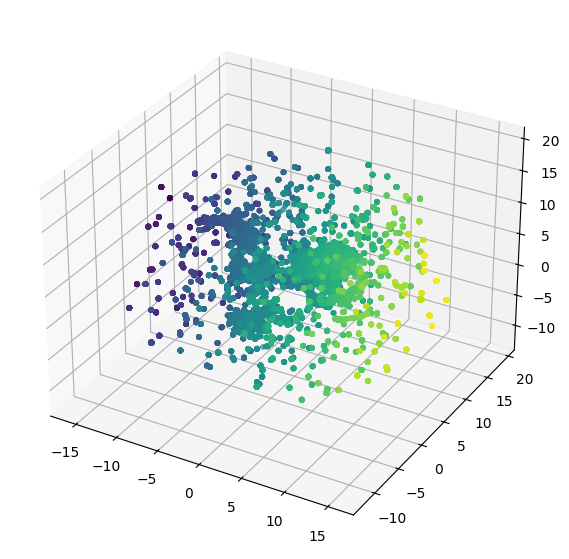

In [12]:
# Reduction of dimension with UMAP
reducer = UMAP(n_neighbors=15, min_dist=0.1, n_components=3, random_state=42, verbose=True)
projection = reducer.fit_transform(mu_embeddings_normalized)

#Vizualizaition of the UMAP space (3D)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(projection[:, 0], projection[:, 1], projection[:, 2], c=projection[:, 0], cmap='viridis', s=10)

## Applciation of Kmeans on reduced space (not used anymore)

In [13]:
#We appy the Kmeans on the reduced space
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(projection)
centroids_kmeans = kmeans.cluster_centers_
labels_kmeans = kmeans.labels_

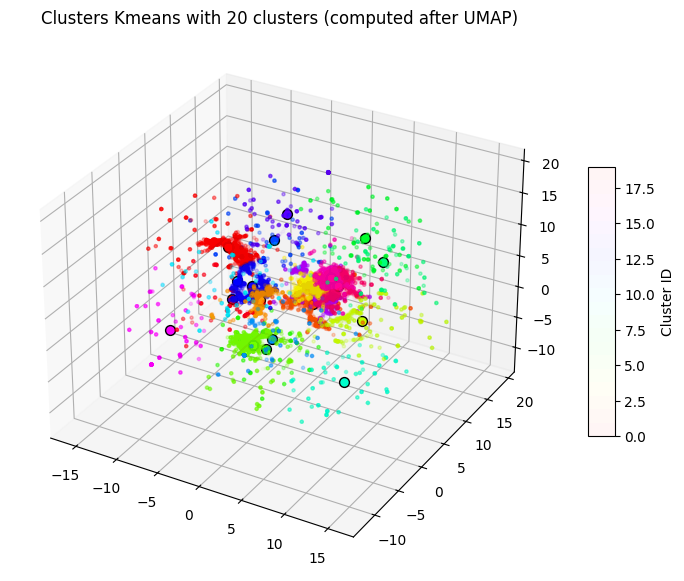

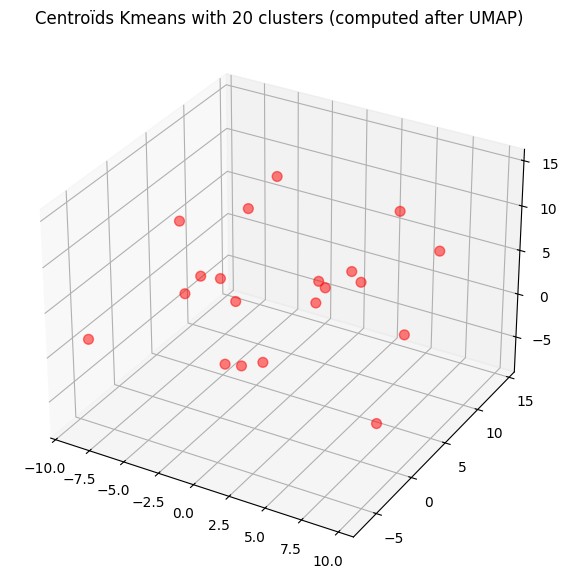

In [14]:
#We plot the results

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter_clusters  = ax.scatter(projection[:, 0], projection[:, 1], projection[:, 2], c=labels_kmeans, s=5, cmap=custom_cmap, alpha = 0.04)
#scatter_clusters  = ax.scatter(centroids_kmeans[:, 0], centroids_kmeans[:, 1], centroids_kmeans[:, 2], c='black', s=50, alpha=1) #If we want centroïds to be black
for i in range(n_clusters):
    ax.scatter(centroids_kmeans[i, 0], centroids_kmeans[i, 1], centroids_kmeans[i, 2], 
               c=colors[i].reshape(1, -1), s=50, edgecolor='black', label=f'Centroid {i}')



cbar = plt.colorbar(scatter_clusters, ax=ax, shrink=0.5, aspect=10)
cbar.set_label("Cluster ID")
plt.title(f"Clusters Kmeans with {n_clusters} clusters (computed after UMAP)")



fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(centroids_kmeans[:, 0], centroids_kmeans[:, 1], centroids_kmeans[:, 2], c='red', s=50, alpha=0.5)
plt.title(f"Centroïds Kmeans with {n_clusters} clusters (computed after UMAP)")
plt.show()


In [15]:
# Silhouette Score
silhouette_avg = silhouette_score(projection, labels_kmeans)
print("Silhouette Score :", silhouette_avg)

Silhouette Score : 0.30745643


## Application of UMAP in 2D (mandatory)

UMAP(n_jobs=1, random_state=42, verbose=True)
Fri Nov  7 00:06:16 2025 Construct fuzzy simplicial set
Fri Nov  7 00:06:16 2025 Finding Nearest Neighbors
Fri Nov  7 00:06:16 2025 Building RP forest with 16 trees


/home/lucas/graph_scenarios/venv/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Nov  7 00:06:16 2025 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	Stopping threshold met -- exiting after 3 iterations
Fri Nov  7 00:06:18 2025 Finished Nearest Neighbor Search
Fri Nov  7 00:06:18 2025 Construct embedding


/home/lucas/graph_scenarios/venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/lucas/graph_scenarios/venv/lib/python3.11/site-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/lucas/graph_scenarios/venv/lib/python3.11/site-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/lucas/graph_scenarios/venv/lib/python3.11/site-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due t

Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Nov  7 00:06:48 2025 Finished embedding


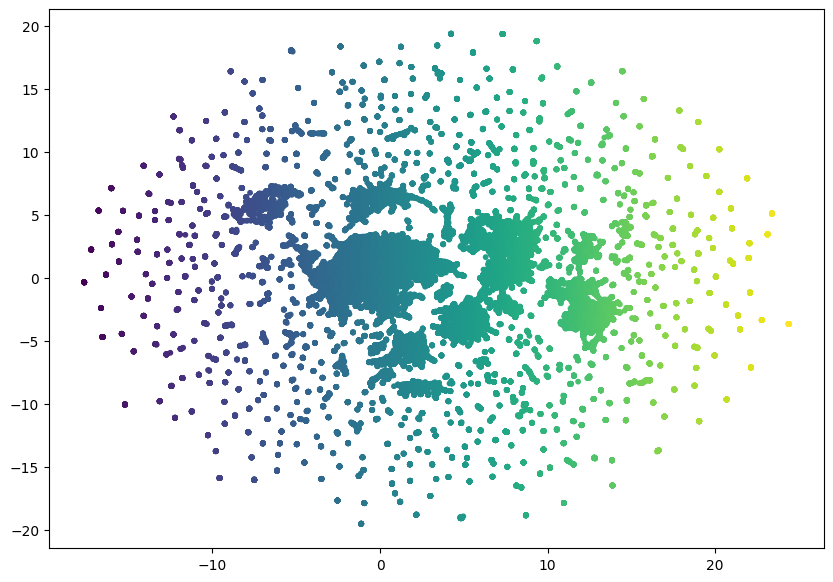

In [16]:
# Reduction of dimension with UMAP in 2D
reducer_2D = UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42, verbose=True)
projection_2D = reducer_2D.fit_transform(mu_embeddings_normalized)

#Vizualizaition of the UMAP space (2D)
fig = plt.figure(figsize=(10, 7))
plt.scatter(projection_2D[:, 0], projection_2D[:, 1], c=projection_2D[:, 0], cmap='viridis', s=10)

## 2.2 Dim reduction PCA

## Reduction of dimension PCA (3D), mandatory

We also try to reduce dimension with PCA (linear so maybe the distance in the "PCA" space is more meaninful than in UMAP space?)

In [17]:
#We compute the PCA of the embeddings
pca = PCA(n_components=3)
pca_projection = pca.fit_transform(mu_embeddings_normalized)


## Application of Kmeans after PCA (3D) (we don't do that anymore)

In [18]:
#We appy the Kmeans on the reduced space after PCA
kmeans_PCA = KMeans(n_clusters=n_clusters, random_state=0)
kmeans_PCA.fit(pca_projection)

centroids_kmeans_PCA  = kmeans_PCA.cluster_centers_
labels_kmeans_PCA  = kmeans_PCA.labels_

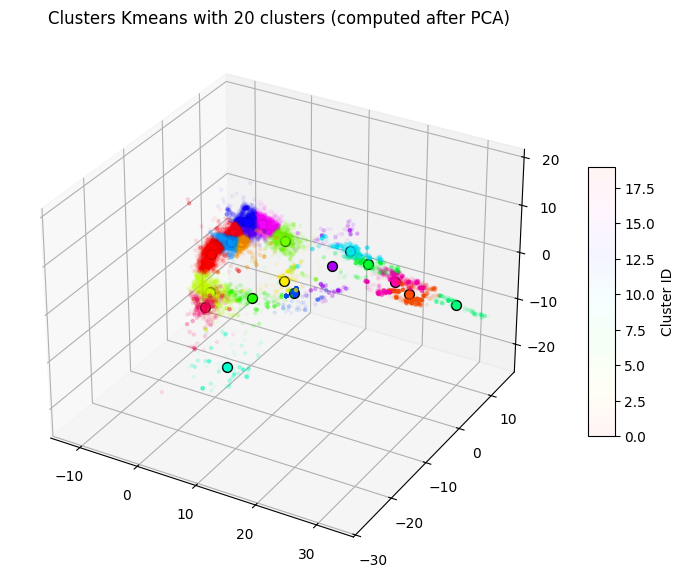

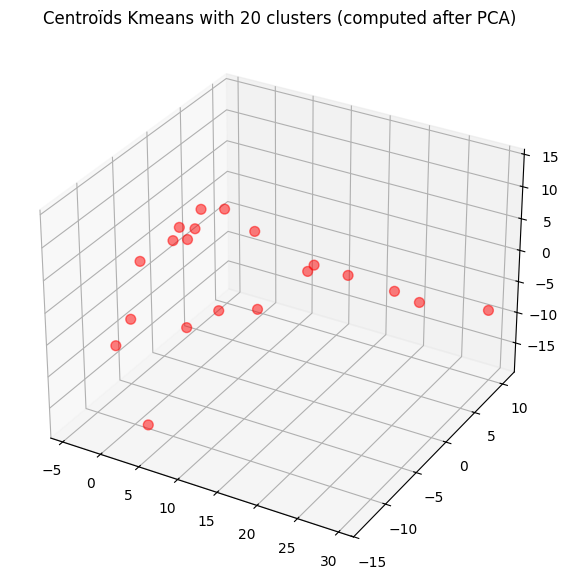

In [19]:
#We plot the results
# Visualiser les clusters and centroids
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter_clusters  = ax.scatter(pca_projection[:, 0], pca_projection[:, 1], pca_projection[:, 2], c=labels_kmeans_PCA, s=5, cmap=custom_cmap, alpha = 0.04)
#scatter_clusters  = ax.scatter(centroids_kmeans[:, 0], centroids_kmeans[:, 1], centroids_kmeans[:, 2], c='black', s=50, alpha=1) #If we want centroïds to be black
for i in range(n_clusters):
    ax.scatter(centroids_kmeans_PCA[i, 0], centroids_kmeans_PCA[i, 1], centroids_kmeans_PCA[i, 2], 
               c=colors[i].reshape(1, -1), s=50, edgecolor='black', label=f'Centroid {i}')



cbar = plt.colorbar(scatter_clusters, ax=ax, shrink=0.5, aspect=10)
cbar.set_label("Cluster ID")
plt.title(f"Clusters Kmeans with {n_clusters} clusters (computed after PCA)")



fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(centroids_kmeans_PCA[:, 0], centroids_kmeans_PCA[:, 1], centroids_kmeans_PCA[:, 2], c='red', s=50, alpha=0.5)
plt.title(f"Centroïds Kmeans with {n_clusters} clusters (computed after PCA)")
plt.show()


In [20]:
# Silhouette Score
silhouette_avg = silhouette_score(pca_projection, labels_kmeans_PCA)
print("Silhouette Score :", silhouette_avg)

Silhouette Score : 0.32049268


# 2 Second approach: clustering before reduction of dimension (used strategy)

## 2.1 We apply K_means on the whole dataset (we don't do that anymore)

In [21]:
#We appy the Kmeans on the whole dataset
kmeans_before = KMeans(n_clusters=n_clusters, random_state=0)
kmeans_before.fit(mu_embeddings_normalized)
centroids_kmeans_before = kmeans_before.cluster_centers_
labels_kmeans_before = kmeans_before.labels_

In [22]:
# Silhouette Score
silhouette_avg = silhouette_score(mu_embeddings_normalized, labels_kmeans_before)
print("Silhouette Score :", silhouette_avg)

Silhouette Score : 0.21487474


## 2.2 Projection in previous UMAP (3D) space to see results

In [23]:
#Project the centroids in the UMAP space
centroids_kmeans_before_projected = reducer.transform(centroids_kmeans_before)

Fri Nov  7 00:07:43 2025 Worst tree score: 0.83059542
Fri Nov  7 00:07:43 2025 Mean tree score: 0.84498728
Fri Nov  7 00:07:43 2025 Best tree score: 0.85508397
Fri Nov  7 00:07:44 2025 Forward diversification reduced edges from 736875 to 322066
Fri Nov  7 00:07:46 2025 Reverse diversification reduced edges from 322066 to 322066
Fri Nov  7 00:07:47 2025 Degree pruning reduced edges from 343968 to 343965
Fri Nov  7 00:07:47 2025 Resorting data and graph based on tree order
Fri Nov  7 00:07:47 2025 Building and compiling search function


Epochs completed:   0%|            0/100 [00:00]

	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs


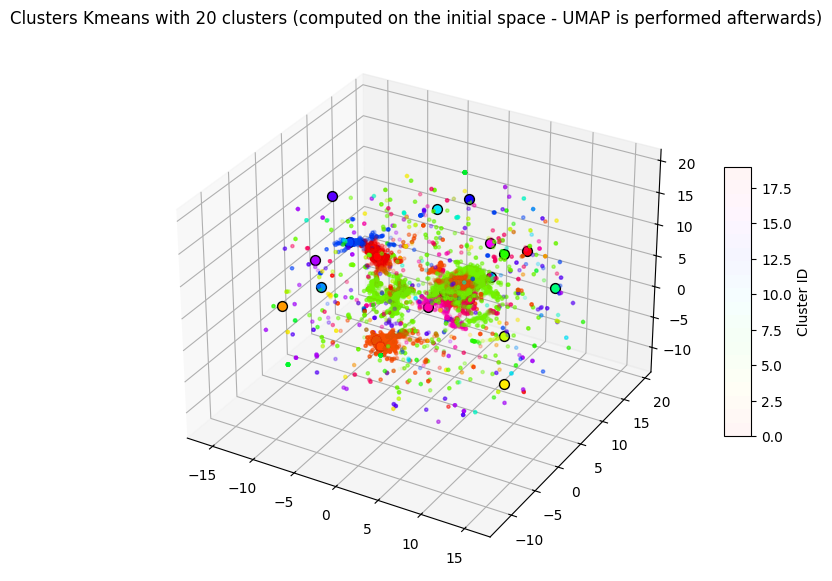

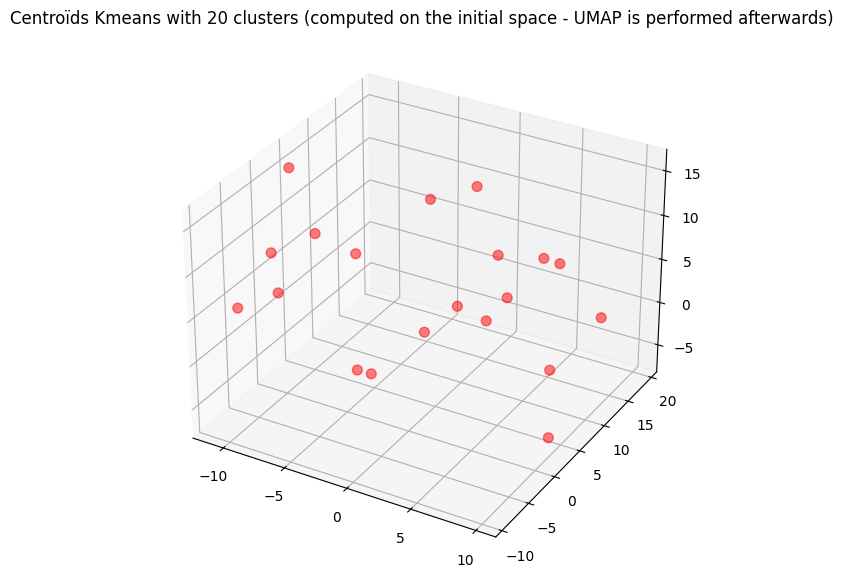

In [24]:
#We plot the results

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter_clusters  = ax.scatter(projection[:, 0], projection[:, 1], projection[:, 2], c=labels_kmeans_before, s=5, cmap=custom_cmap, alpha = 0.04)
for i in range(n_clusters):
    ax.scatter(centroids_kmeans_before_projected[i, 0], centroids_kmeans_before_projected[i, 1], centroids_kmeans_before_projected[i, 2], 
               c=colors[i].reshape(1, -1), s=50, edgecolor='black', label=f'Centroid {i}')



cbar = plt.colorbar(scatter_clusters, ax=ax, shrink=0.5, aspect=10)
cbar.set_label("Cluster ID")
plt.title(f"Clusters Kmeans with {n_clusters} clusters (computed on the initial space - UMAP is performed afterwards)")



fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(centroids_kmeans_before_projected[:, 0], centroids_kmeans_before_projected[:, 1], centroids_kmeans_before_projected[:, 2], c='red', s=50, alpha=0.5)
plt.title(f"Centroïds Kmeans with {n_clusters} clusters (computed on the initial space - UMAP is performed afterwards)")
plt.show()


## 2.3 Projection with PCA to see results

## PCA 3D

In [25]:
#Project the centroids in the PCA space
centroids_kmeans_before_projected = pca.transform(centroids_kmeans_before)

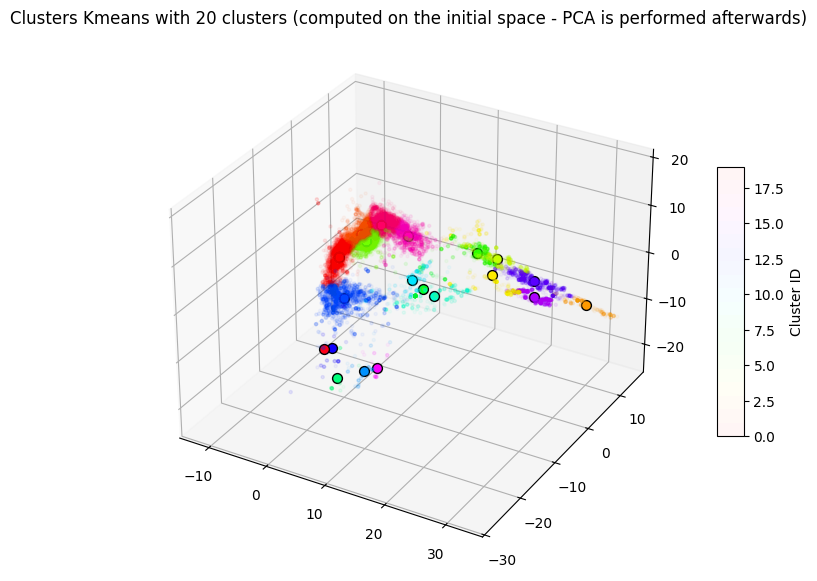

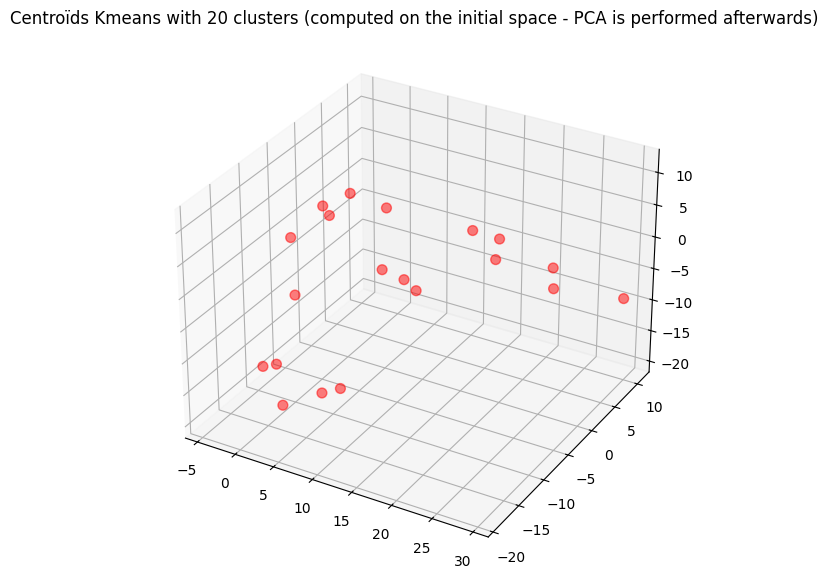

In [26]:
#We plot the results
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter_clusters  = ax.scatter(pca_projection[:, 0], pca_projection[:, 1], pca_projection[:, 2], c=labels_kmeans_before, s=5, cmap=custom_cmap, alpha = 0.04)
for i in range(n_clusters):
    ax.scatter(centroids_kmeans_before_projected[i, 0], centroids_kmeans_before_projected[i, 1], centroids_kmeans_before_projected[i, 2], 
               c=colors[i].reshape(1, -1), s=50, edgecolor='black', label=f'Centroid {i}')



cbar = plt.colorbar(scatter_clusters, ax=ax, shrink=0.5, aspect=10)
cbar.set_label("Cluster ID")
plt.title(f"Clusters Kmeans with {n_clusters} clusters (computed on the initial space - PCA is performed afterwards)")



fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(centroids_kmeans_before_projected[:, 0], centroids_kmeans_before_projected[:, 1], centroids_kmeans_before_projected[:, 2], c='red', s=50, alpha=0.5)
plt.title(f"Centroïds Kmeans with {n_clusters} clusters (computed on the initial space - PCA is performed afterwards)")
plt.show()

## PCA 2D

### Run the next cell for cvreate the PCA 2D Space (mandatory) but the following ones are not used anymore

In [27]:
#PCA 2D
pca_2d = PCA(n_components=2)
pca_projection_2d = pca_2d.fit_transform(mu_embeddings_normalized)

In [28]:
#Project the centroids in the PCA space
centroids_kmeans_2d = pca_2d.transform(centroids_kmeans_before)

In [29]:
print(len(pca_projection_2d[:,0]))
len(labels_kmeans_before)

49125


49125

/tmp/ipykernel_2642208/1761195679.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(centroids_kmeans_2d[i, 0], centroids_kmeans_2d[i, 1],


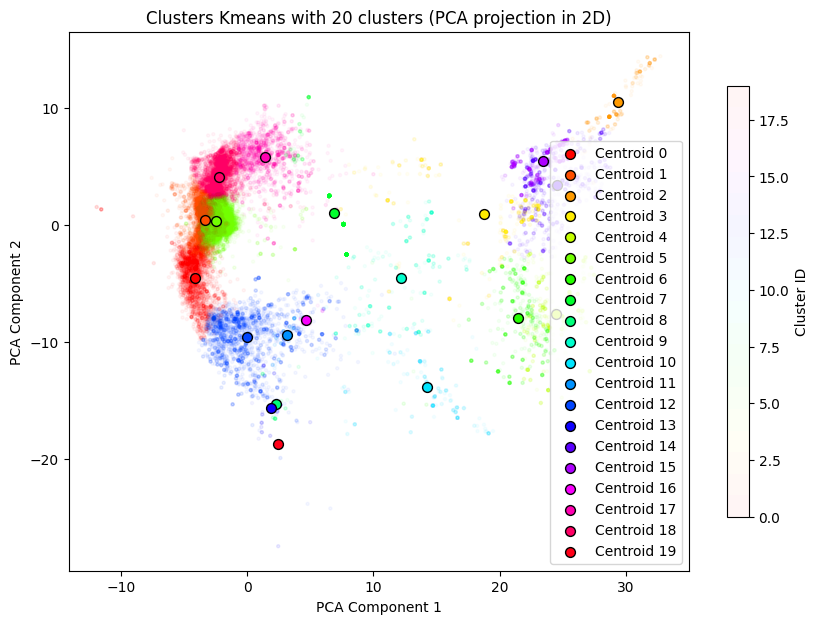

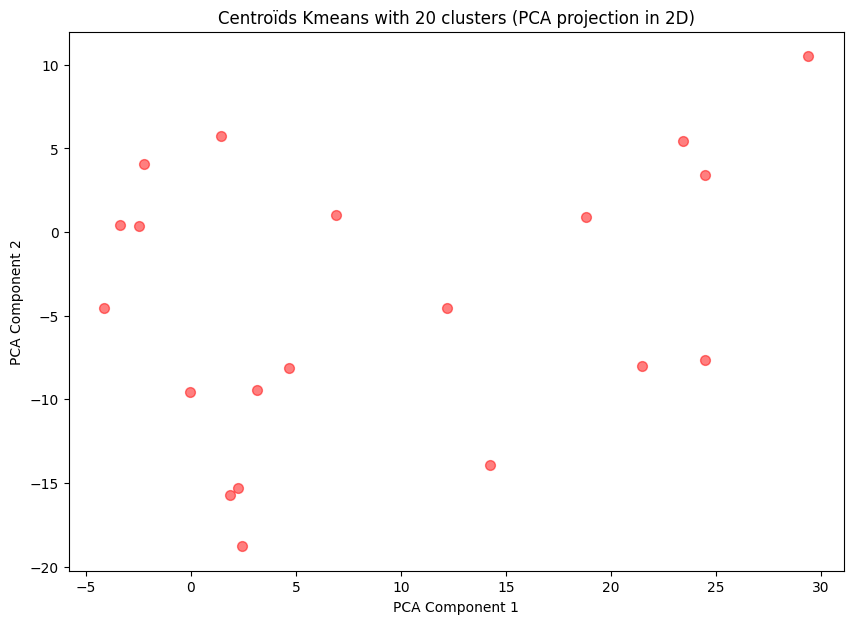

In [30]:
fig, ax = plt.subplots(figsize=(10, 7))
scatter_clusters_2d = ax.scatter(pca_projection_2d[:, 0], pca_projection_2d[:, 1],
                                 c=labels_kmeans_before, s=5, cmap=custom_cmap, alpha=0.04)

#Add centroïds
for i in range(n_clusters):
    ax.scatter(centroids_kmeans_2d[i, 0], centroids_kmeans_2d[i, 1],
               c=colors_2D[i], s=50, edgecolor='black', label=f'Centroid {i}')


cbar = plt.colorbar(scatter_clusters_2d, ax=ax, shrink=0.8, aspect=20)
cbar.set_label("Cluster ID")


plt.title(f"Clusters Kmeans with {n_clusters} clusters (PCA projection in 2D)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()


fig, ax = plt.subplots(figsize=(10, 7))
ax.scatter(centroids_kmeans_2d[:, 0], centroids_kmeans_2d[:, 1], c='red', s=50, alpha=0.5)
plt.title(f"Centroïds Kmeans with {n_clusters} clusters (PCA projection in 2D)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

# We want to look quickly to see whether or not we have curse of dimensionality

## We check the histogram of euclidian distances in the original latent space

Data shape: (49125, 128)


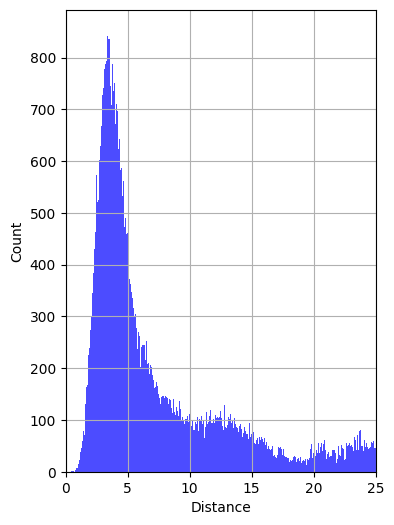

Moyenne des distances : 11.5012
Écart type des distances : 10.8814


<Figure size 640x480 with 0 Axes>

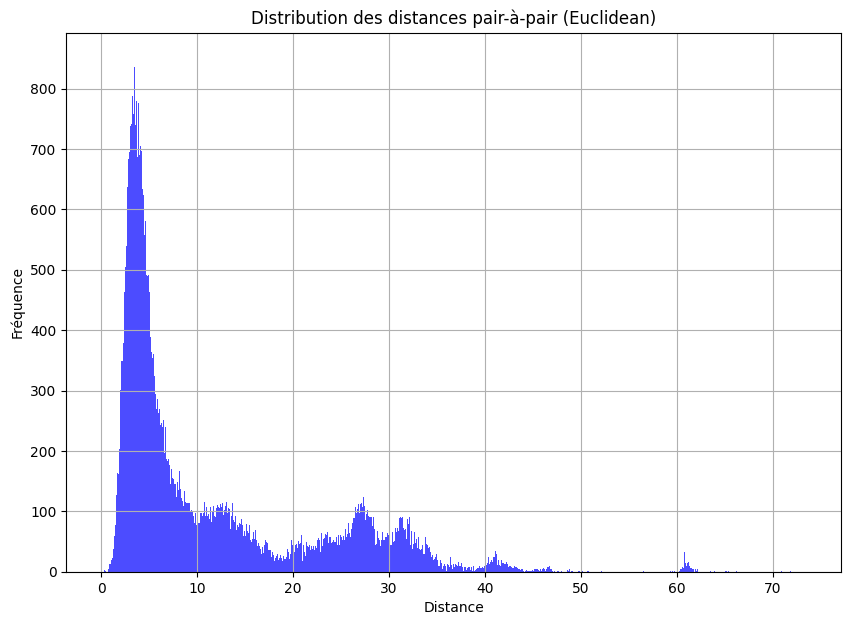

In [31]:
print(f"Data shape: {mu_embeddings_normalized.shape}")


sample_size = 1000  # Limit to 1000 points if needed
if mu_embeddings_normalized.shape[0] > sample_size:
    indices = np.random.choice(mu_embeddings_normalized.shape[0], size=sample_size, replace=False)
    sampled_data = mu_embeddings_normalized[indices]
else:
    sampled_data = mu_embeddings_normalized


distances = pdist(sampled_data, metric='euclidean')


plt.figure(figsize=(4,6))
plt.hist(distances, bins=8000, color='blue', alpha=0.7)
#plt.title("Distribution des distances pair-à-pair (Euclidean)")
plt.xlabel("Distance")
plt.ylabel("Count")
plt.xlim(0,25)
#plt.ylim(0, 5.3E6)
plt.grid()
plt.show()
sns.despine()

# Étape 5 : Vérifier l'écart type et la moyenne
mean_distance = np.mean(distances)
std_distance = np.std(distances)
print(f"Moyenne des distances : {mean_distance:.4f}")
print(f"Écart type des distances : {std_distance:.4f}")
sns.despine()
plt.savefig(
    "Figure_distribution_pairwise_distances_{}.jpg".format(name_extension),
    format="jpg",             
    dpi=300,                  
    bbox_inches="tight",      
    pad_inches=0.05           
)


plt.figure(figsize=(10,7))
plt.hist(distances, bins=8000, color='blue', alpha=0.7)
plt.title("Distribution des distances pair-à-pair (Euclidean)")
plt.xlabel("Distance")
plt.ylabel("Fréquence")
plt.grid()
plt.show()

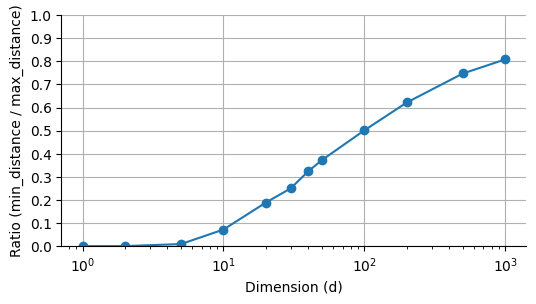

In [32]:
n_points = 10000
dims = [1, 2, 5, 10, 20, 30, 40, 50, 100, 200, 500, 1000]

ratios = []

for d in dims:
    data = np.random.rand(n_points, d)
    distances = pdist(data, metric='euclidean')
    min_dist = np.min(distances)
    max_dist = np.max(distances)
    ratio = min_dist / max_dist
    ratios.append(ratio)

plt.figure(figsize=(6, 3))
plt.plot(dims, ratios, marker='o')
plt.xlabel("Dimension (d)")
plt.ylabel("Ratio (min_distance / max_distance)")
plt.ylim(0, 1)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xscale("log")
plt.grid(True)
sns.despine()
plt.show()

## Clustering with KMedoids before dim reduction (Most important part !)

In [33]:
from sklearn_extra.cluster import KMedoids


kmedoids_before = KMedoids(n_clusters=n_clusters, metric="euclidean", random_state=0)
kmedoids_before.fit(mu_embeddings_normalized)

centroids_kmedoids_before = kmedoids_before.cluster_centers_
labels_kmedoids_before = kmedoids_before.labels_


/home/lucas/graph_scenarios/venv/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 16 is empty! self.labels_[self.medoid_indices_[16]] may not be labeled with its corresponding cluster (16).
  warnings.warn(


In [34]:
index_of_medoids = kmedoids_before.medoid_indices_
corresponding_medioid_embedding_space = mu_embeddings[index_of_medoids]
print(corresponding_medioid_embedding_space.shape)

(20, 128)


In [35]:
#Prepare the data for the csv
corresponding_medioid_embedding_space_csv = pd.DataFrame(corresponding_medioid_embedding_space, columns=[f"dim_{i}" for i in range(1,corresponding_medioid_embedding_space.shape[1] + 1)])
corresponding_medioid_embedding_space_csv["Method"] = "KMedoids_{i}_clusters_{j}".format(i=n_clusters,j=name_extension)
corresponding_medioid_embedding_space_csv["index_in_embedding_space"] = index_of_medoids
corresponding_medioid_embedding_space_csv.head()

dim_1     dim_2     dim_3  dim_4  dim_5  dim_6     dim_7     dim_8  \
0  0.020085  0.011825  0.096688    0.0    0.0    0.0  0.000085  0.072726   
1  0.019648  0.006544  0.092298    0.0    0.0    0.0  0.000029  0.069649   
2  0.019551  0.016705  0.092973    0.0    0.0    0.0  0.000177  0.070564   
3  0.011883  0.015591  0.089339    0.0    0.0    0.0  0.000131  0.081599   
4  0.021946  0.013999  0.094108    0.0    0.0    0.0  0.000080  0.071696   

      dim_9    dim_10  ...   dim_121   dim_122   dim_123   dim_124   dim_125  \
0  0.045230  0.013960  ...  0.035804  0.040969  0.084238  0.030912  0.094062   
1  0.049060  0.009051  ...  0.035858  0.044834  0.086281  0.037168  0.095098   
2  0.046661  0.015386  ...  0.031299  0.037707  0.083969  0.029179  0.091307   
3  0.041347  0.007945  ...  0.049188  0.046530  0.108392  0.005236  0.062227   
4  0.051331  0.010828  ...  0.032771  0.044724  0.092584  0.032731  0.088115   

    dim_126   dim_127   dim_128                             Method  \
0  0.017044  0.039952  0.057253  KMedoids_20_clusters_graph_vae_v3   
1  0.017351  0.040856  0.064103  KMedoids_20_clusters_graph_vae_v3   
2  0.016494  0.039400  0.050606  KMedoids_20_clusters_graph_vae_v3   
3  0.021275  0.006456  0.031690  KMedoids_20_clusters_graph_vae_v3   
4  0.016649  0.039021  0.057312  KMedoids_20_clusters_graph_vae_v3   

   index_in_embedding_space  
0                      6084  
1                     41319  
2                     31793  
3                     41411  
4                     18521  

[5 rows x 130 columns]

In [36]:
#Export results to csv

corresponding_medioid_embedding_space_csv.to_csv(".\embeddings\medioidsTEST_{}_{}.csv".format(n_clusters,name_extension), index=False)


## Vizualization with UMAP 3D

In [37]:
# Get back the orginal points of the centroïds
index_of_medoids = kmedoids_before.medoid_indices_

#Check that foudnback existing points with medoids indixes
print(np.unique(kmedoids_before.cluster_centers_ - mu_embeddings_normalized[index_of_medoids]))

[0.]


In [38]:
# Silhouette Score
silhouette_avg = silhouette_score(mu_embeddings_normalized, labels_kmedoids_before)
print("Silhouette Score :", silhouette_avg)

Silhouette Score : 0.065588415


In [39]:
#Find back the medoids in the UMAP space
centroids_kmedoids_before_projected = projection[index_of_medoids]

#Check that if we project afterwards, we have the same
print(reducer.transform(centroids_kmedoids_before)[0:7])
print(centroids_kmedoids_before_projected[0:7])

Epochs completed:   0%|            0/100 [00:00]

	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs
[[ 5.0094366   3.9794936   6.93785   ]
 [-0.56179667  7.626761    1.1534886 ]
 [ 3.738186    4.874508    8.030427  ]
 [-5.3359103   3.6149194   7.5448527 ]
 [ 5.5242157   1.107803    5.0872393 ]
 [-2.2232342  -2.5155003  -0.9686326 ]
 [-3.0316122   1.9141227   4.074343  ]]
[[ 4.963004   3.9570239  6.890558 ]
 [-0.5714004  7.631193   1.1192495]
 [ 3.693144   4.8487077  8.043754 ]
 [-5.6332436  3.6974638  7.6063175]
 [ 5.5231314  1.108716   5.08765  ]
 [-2.1917326 -2.464086  -0.9818737]
 [-2.8871493  1.9364394  4.1087317]]


In [40]:
for i in range(n_clusters):
    print(centroids_kmedoids_before_projected[i, 0], centroids_kmedoids_before_projected[i, 1], centroids_kmedoids_before_projected[i, 2])

4.963004 3.9570239 6.890558
-0.5714004 7.631193 1.1192495
3.693144 4.8487077 8.043754
-5.6332436 3.6974638 7.6063175
5.5231314 1.108716 5.08765
-2.1917326 -2.464086 -0.9818737
-2.8871493 1.9364394 4.1087317
4.2177105 6.918539 5.265731
-0.51552004 -0.24493232 6.243407
2.8123403 5.2258034 6.5258584
-0.7618406 1.213777 5.1551313
-2.0303264 9.088081 3.1128094
3.2194948 3.6658745 5.495225
-8.922976 3.226338 8.979875
-0.45383346 9.012675 -1.7240117
3.3058023 3.4933255 5.616481
2.299403 9.275433 9.640377
5.7538776 9.664749 15.406205
5.0440254 6.131152 6.0699787
3.3141215 6.057458 4.5426702


In [41]:
centroids_kmedoids_before_projected[:, 0], centroids_kmedoids_before_projected[:, 1], centroids_kmedoids_before_projected[:, 2]

(array([ 4.963004  , -0.5714004 ,  3.693144  , -5.6332436 ,  5.5231314 ,
        -2.1917326 , -2.8871493 ,  4.2177105 , -0.51552004,  2.8123403 ,
        -0.7618406 , -2.0303264 ,  3.2194948 , -8.922976  , -0.45383346,
         3.3058023 ,  2.299403  ,  5.7538776 ,  5.0440254 ,  3.3141215 ],
       dtype=float32),
 array([ 3.9570239 ,  7.631193  ,  4.8487077 ,  3.6974638 ,  1.108716  ,
        -2.464086  ,  1.9364394 ,  6.918539  , -0.24493232,  5.2258034 ,
         1.213777  ,  9.088081  ,  3.6658745 ,  3.226338  ,  9.012675  ,
         3.4933255 ,  9.275433  ,  9.664749  ,  6.131152  ,  6.057458  ],
       dtype=float32),
 array([ 6.890558 ,  1.1192495,  8.043754 ,  7.6063175,  5.08765  ,
        -0.9818737,  4.1087317,  5.265731 ,  6.243407 ,  6.5258584,
         5.1551313,  3.1128094,  5.495225 ,  8.979875 , -1.7240117,
         5.616481 ,  9.640377 , 15.406205 ,  6.0699787,  4.5426702],
       dtype=float32))

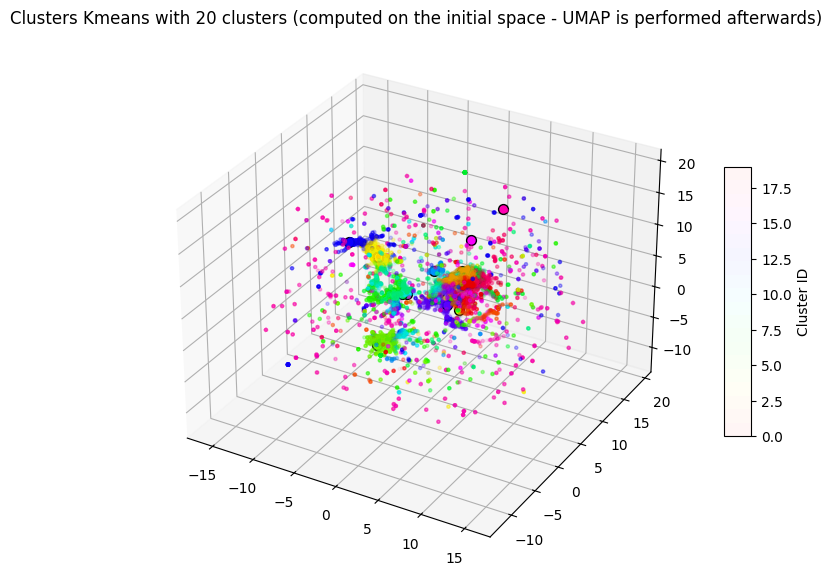

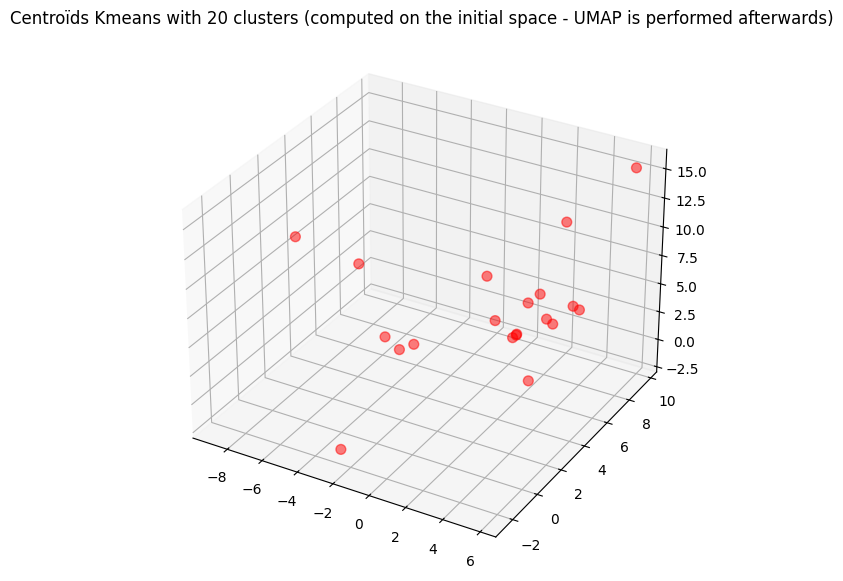

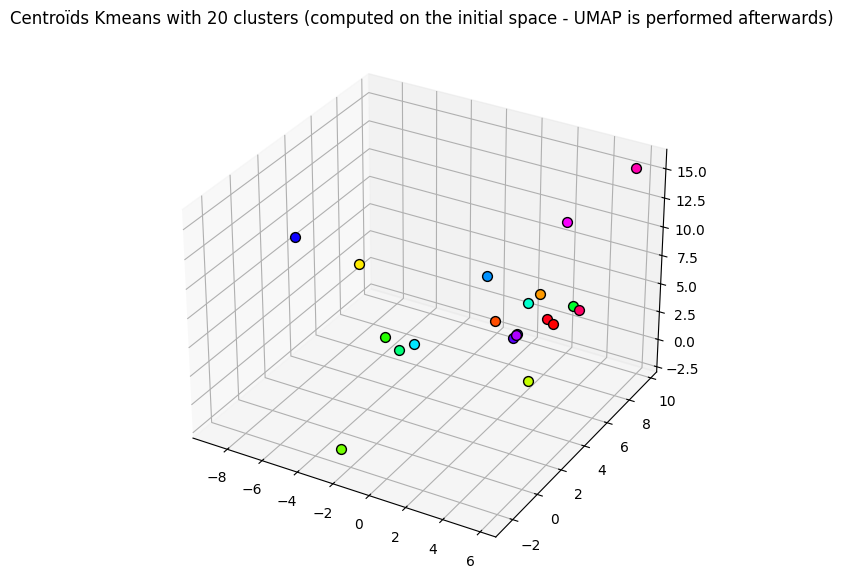

In [42]:
#We plot the results

# Visualiser les clusters and centroids
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter_clusters  = ax.scatter(projection[:, 0], projection[:, 1], projection[:, 2], c=labels_kmedoids_before, s=5, cmap=custom_cmap, alpha = 0.04)
for i in range(n_clusters):
    ax.scatter(centroids_kmedoids_before_projected[i, 0], centroids_kmedoids_before_projected[i, 1], centroids_kmedoids_before_projected[i, 2], 
               c=colors[i].reshape(1, -1), s=50, edgecolor='black', label=f'Centroid {i}')



cbar = plt.colorbar(scatter_clusters, ax=ax, shrink=0.5, aspect=10)
cbar.set_label("Cluster ID")
plt.title(f"Clusters Kmeans with {n_clusters} clusters (computed on the initial space - UMAP is performed afterwards)")



fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(centroids_kmedoids_before_projected[:, 0], centroids_kmedoids_before_projected[:, 1], centroids_kmedoids_before_projected[:, 2], c='red', s=50, alpha=0.5)
plt.title(f"Centroïds Kmeans with {n_clusters} clusters (computed on the initial space - UMAP is performed afterwards)")


fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
for i in range(n_clusters):
    ax.scatter(centroids_kmedoids_before_projected[i, 0], centroids_kmedoids_before_projected[i, 1], centroids_kmedoids_before_projected[i, 2], 
               c=colors[i].reshape(1, -1), s=50, edgecolor='black', label=f'Centroid {i}')
plt.title(f"Centroïds Kmeans with {n_clusters} clusters (computed on the initial space - UMAP is performed afterwards)")


plt.show()


## UMAP 2D

In [43]:
#Find back the medoids in the UMAP space (2D)
centroids_kmedoids_before_projected_2D = projection_2D[index_of_medoids]

#Check that if we project afterwards, we have the same
print(reducer_2D.transform(centroids_kmedoids_before)[0:7])
print(centroids_kmedoids_before_projected_2D[0:7])

Fri Nov  7 00:09:31 2025 Worst tree score: 0.83059542
Fri Nov  7 00:09:31 2025 Mean tree score: 0.84498728
Fri Nov  7 00:09:31 2025 Best tree score: 0.85508397
Fri Nov  7 00:09:31 2025 Forward diversification reduced edges from 736875 to 322066
Fri Nov  7 00:09:31 2025 Reverse diversification reduced edges from 322066 to 322066
Fri Nov  7 00:09:31 2025 Degree pruning reduced edges from 343968 to 343965
Fri Nov  7 00:09:31 2025 Resorting data and graph based on tree order
Fri Nov  7 00:09:31 2025 Building and compiling search function


Epochs completed:   0%|            0/100 [00:00]

	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs
[[-0.10852361  2.285736  ]
 [ 3.2588809  -8.533731  ]
 [-1.0377519   3.1085844 ]
 [ 5.0711904  -3.1479561 ]
 [-7.783925   -2.0877    ]
 [12.765565   -3.0931733 ]
 [ 8.924986    2.2306838 ]]
[[-0.02881288  2.2469292 ]
 [ 3.3067687  -8.603821  ]
 [-1.0094436   3.0328634 ]
 [ 4.896311   -3.4786017 ]
 [-7.7830114  -2.0870397 ]
 [12.802028   -3.0213125 ]
 [ 8.826668    2.1315506 ]]


In [44]:
#Check of the order of labels and centroïds
unique_labels = sorted(set(labels_kmedoids_before))
expected_labels = list(range(n_clusters))

if unique_labels == expected_labels:
    print("✅ Les labels des clusters correspondent aux indices des centroïdes.")
else:
    print("❌ Les labels des clusters ne correspondent pas aux indices des centroïdes.")
    print(f"Labels trouvés : {unique_labels}")
    print(f"Labels attendus : {expected_labels}")


✅ Les labels des clusters correspondent aux indices des centroïdes.


/tmp/ipykernel_2642208/2787451743.py:6: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(centroids_kmedoids_before_projected_2D[i, 0], centroids_kmedoids_before_projected_2D[i, 1],


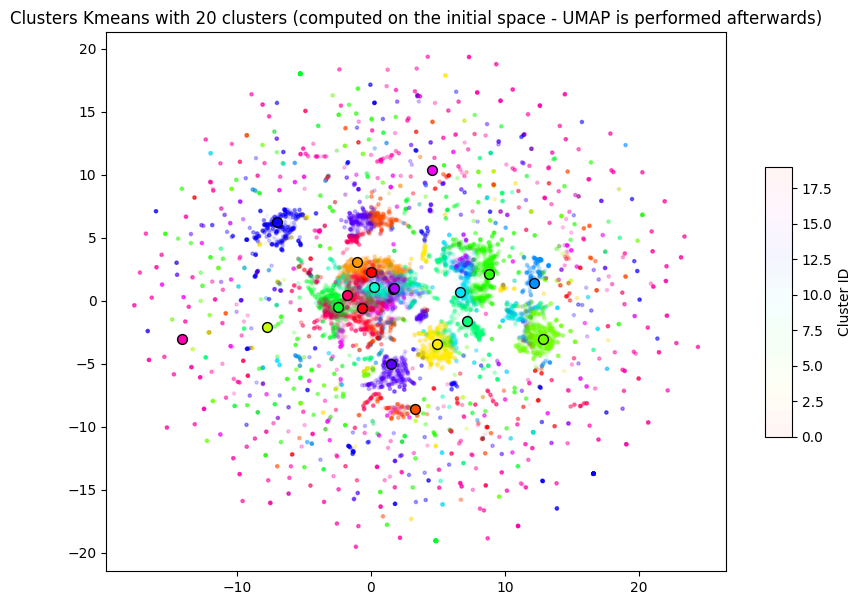

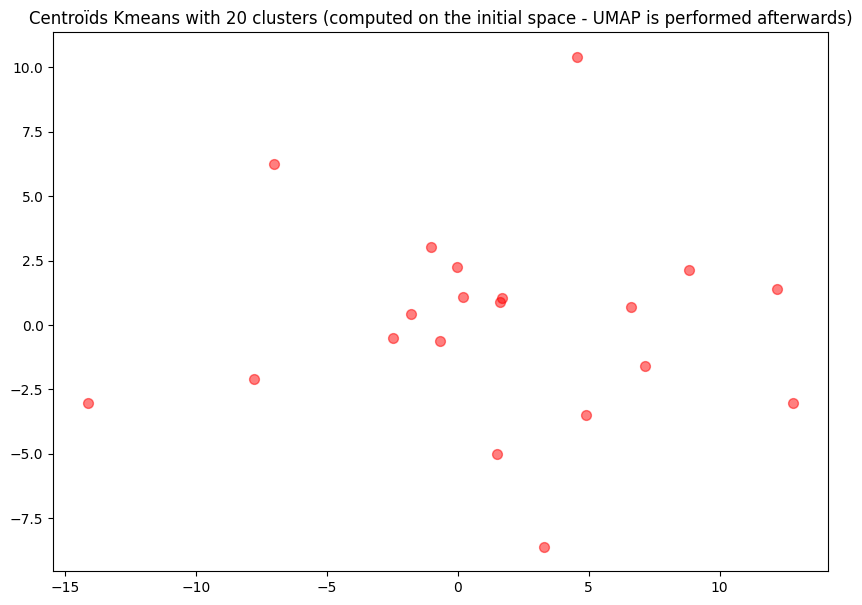

/tmp/ipykernel_2642208/2787451743.py:27: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(centroids_kmedoids_before_projected_2D[i, 0], centroids_kmedoids_before_projected_2D[i, 1],


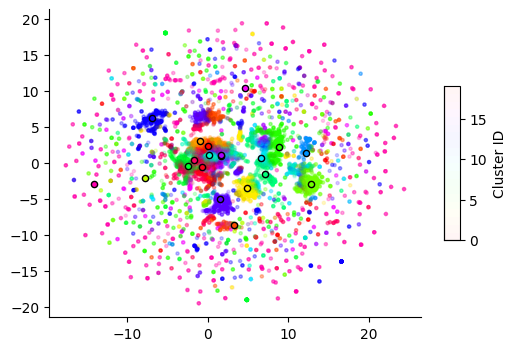

In [45]:
#We plot the results
fig, ax = plt.subplots(figsize=(10, 7))

scatter_clusters  = ax.scatter(projection_2D[:, 0], projection_2D[:, 1], c=labels_kmedoids_before, s=5, cmap=custom_cmap, alpha = 0.04)
for i in range(n_clusters):
    ax.scatter(centroids_kmedoids_before_projected_2D[i, 0], centroids_kmedoids_before_projected_2D[i, 1], 
               c=colors_2D[i], s=50, edgecolor='black', label=f'Centroid {i}')



cbar = plt.colorbar(scatter_clusters, ax=ax, shrink=0.5, aspect=10)
cbar.set_label("Cluster ID")
plt.title(f"Clusters Kmeans with {n_clusters} clusters (computed on the initial space - UMAP is performed afterwards)")



fig, ax = plt.subplots(figsize=(10, 7))
scatter = ax.scatter(centroids_kmedoids_before_projected_2D[:, 0], centroids_kmedoids_before_projected_2D[:, 1], c='red', s=50, alpha=0.5)
plt.title(f"Centroïds Kmeans with {n_clusters} clusters (computed on the initial space - UMAP is performed afterwards)")
plt.show()


fig, ax = plt.subplots(figsize=(6,4))

scatter_clusters  = ax.scatter(projection_2D[:, 0], projection_2D[:, 1], c=labels_kmedoids_before, s=5, cmap=custom_cmap, alpha = 0.04)
for i in range(n_clusters):
    ax.scatter(centroids_kmedoids_before_projected_2D[i, 0], centroids_kmedoids_before_projected_2D[i, 1], 
               c=colors_2D[i], s=20, edgecolor='black', label=f'Centroid {i}')



cbar = plt.colorbar(scatter_clusters, ax=ax, shrink=0.5, aspect=10)
cbar.set_label("Cluster ID")
#plt.title(f"Clusters Kmeans with {n_clusters} clusters (computed on the initial space - UMAP is performed afterwards)")
sns.despine()
plt.show()






## PCA (3D)

In [46]:
#Project the centroids in the PCA space 3D
centroids_kmedoids_before_projected_PCA = pca_projection[index_of_medoids]

In [47]:
centroids_kmedoids_before_projected_PCA

array([[-2.7606127e+00,  1.2123206e+00,  1.0696323e+00],
       [-2.8518589e+00,  2.1455014e+00,  1.1318737e+00],
       [-2.3135717e+00,  1.6638555e-01,  8.8540769e-01],
       [-4.5228977e+00, -3.5106435e+00,  8.0474690e-03],
       [-2.2375741e+00,  5.3812152e-01,  5.7526237e-01],
       [-3.3221195e+00,  5.0672650e-01,  1.2451766e+00],
       [-3.2293222e+00, -2.0923847e-02,  7.4896179e-02],
       [-1.6654048e+00,  7.8047478e-01, -4.7267914e-01],
       [-2.9963136e+00, -6.1363417e-01,  3.0059898e-01],
       [-2.2314920e+00, -8.2656480e-02, -5.0030004e-02],
       [-3.0521510e+00, -2.4626729e-01,  1.0857672e-01],
       [-3.6956224e+00,  1.7894231e+00,  1.8141408e+00],
       [-2.7778063e+00,  6.8136215e-01,  2.3279510e-01],
       [ 2.0276973e-01, -8.8009739e+00, -4.6479254e+00],
       [-6.1234611e-01,  5.2493343e+00,  7.2319710e-01],
       [-2.7587256e+00,  4.2990702e-01,  3.2475913e-01],
       [-2.1612141e+00,  3.7891379e-01,  4.3677934e-02],
       [ 2.1975294e+01,  1.1033

In [48]:
centroids_kmedoids_before_projected_PCA[:,0]

array([-2.7606127 , -2.8518589 , -2.3135717 , -4.5228977 , -2.237574  ,
       -3.3221195 , -3.2293222 , -1.6654048 , -2.9963136 , -2.231492  ,
       -3.052151  , -3.6956224 , -2.7778063 ,  0.20276973, -0.6123461 ,
       -2.7587256 , -2.161214  , 21.975294  , -2.2733877 , -2.272064  ],
      dtype=float32)

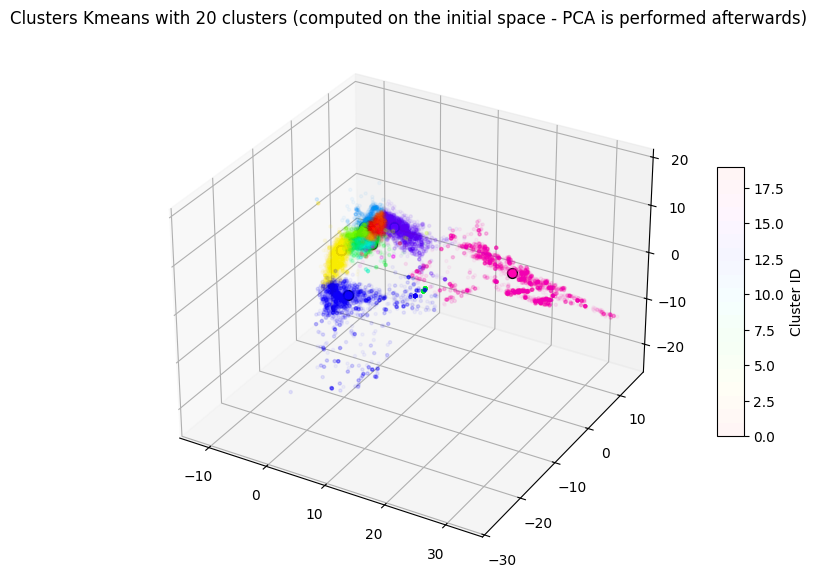

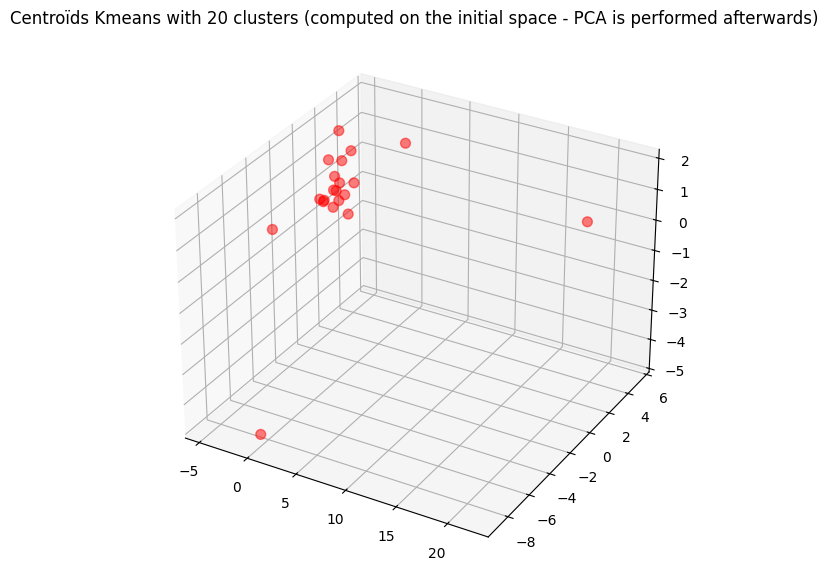

In [49]:
#We plot the results
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
for i in range(n_clusters):
    ax.scatter(centroids_kmedoids_before_projected_PCA[i, 0], centroids_kmedoids_before_projected_PCA[i, 1], centroids_kmedoids_before_projected_PCA[i, 2], 
               c=colors[i].reshape(1, -1), s=50, edgecolor='black', label=f'Centroid {i}')
    
scatter_clusters  = ax.scatter(pca_projection[:, 0], pca_projection[:, 1], pca_projection[:, 2], c=labels_kmedoids_before, s=5, cmap=custom_cmap, alpha = 0.04)
   


cbar = plt.colorbar(scatter_clusters, ax=ax, shrink=0.5, aspect=10)
cbar.set_label("Cluster ID")
plt.title(f"Clusters Kmeans with {n_clusters} clusters (computed on the initial space - PCA is performed afterwards)")



fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(centroids_kmedoids_before_projected_PCA[:, 0], centroids_kmedoids_before_projected_PCA[:, 1], centroids_kmedoids_before_projected_PCA[:, 2], c='red', s=50, alpha=0.5)
plt.title(f"Centroïds Kmeans with {n_clusters} clusters (computed on the initial space - PCA is performed afterwards)")
plt.show()


## PCA 2D

In [50]:
#Project the centroids in the PCA space 2D

centroids_kmedoids_before_projected_PCA_2D = pca_projection_2d[index_of_medoids]

/tmp/ipykernel_2642208/4038827787.py:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(centroids_kmedoids_before_projected_PCA_2D[i, 0], centroids_kmedoids_before_projected_PCA_2D[i, 1],


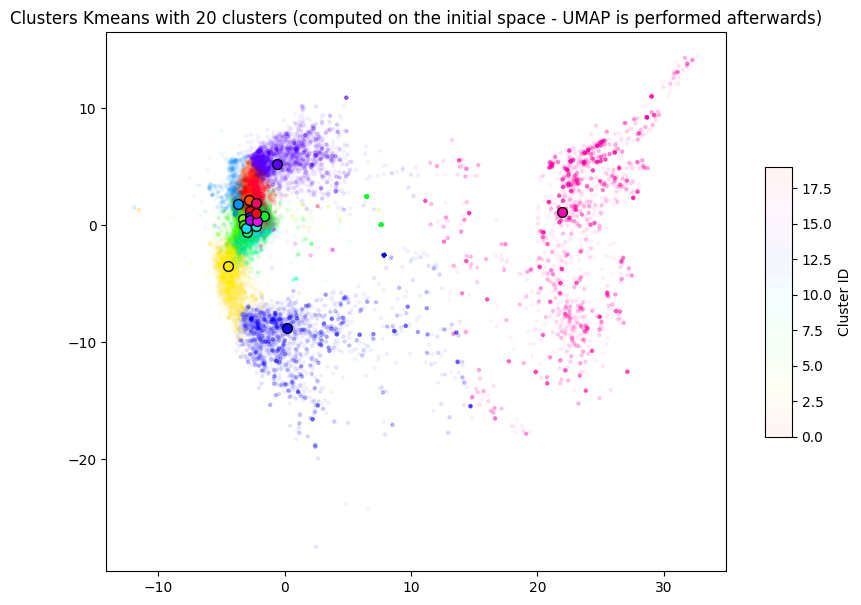

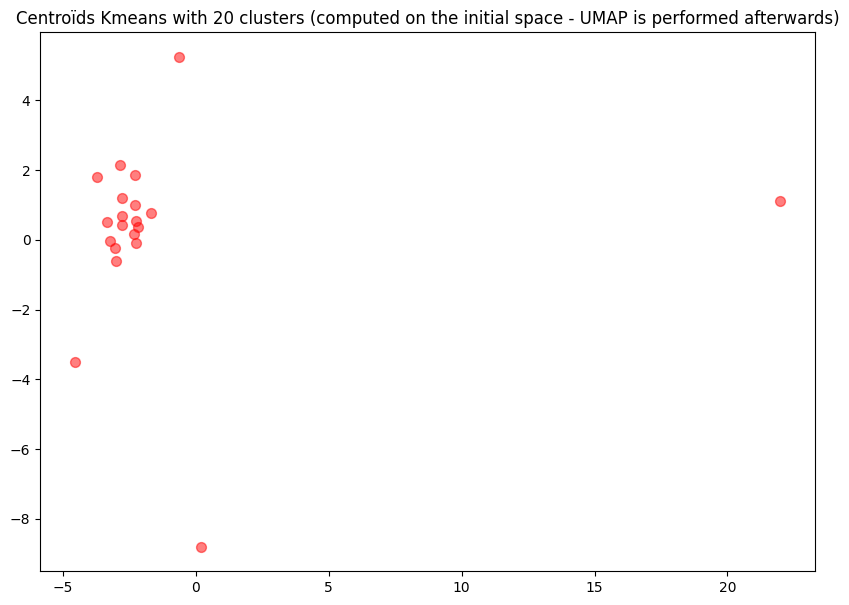

/tmp/ipykernel_2642208/4038827787.py:31: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(centroids_kmedoids_before_projected_PCA_2D[i, 0], centroids_kmedoids_before_projected_PCA_2D[i, 1],


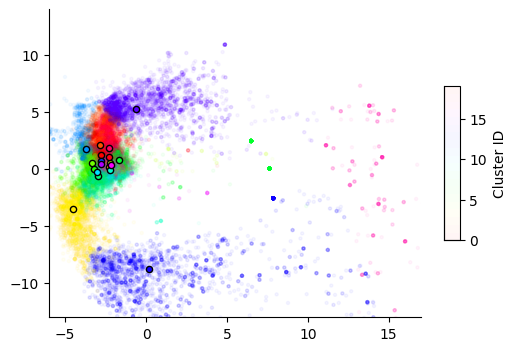

In [51]:
#We plot the results
colors_2D = custom_cmap.colors if hasattr(custom_cmap, "colors") else plt.cm.hsv(np.linspace(0, 1, n_clusters))

# Visualiser les clusters and centroids
fig, ax = plt.subplots(figsize=(10, 7))

scatter_clusters  = ax.scatter(pca_projection_2d[:, 0], pca_projection_2d[:, 1], c=labels_kmedoids_before, s=5, cmap=custom_cmap, alpha = 0.04)
for i in range(n_clusters):
    ax.scatter(centroids_kmedoids_before_projected_PCA_2D[i, 0], centroids_kmedoids_before_projected_PCA_2D[i, 1], 
               c=colors_2D[i], s=50, edgecolor='black', label=f'Centroid {i}')



cbar = plt.colorbar(scatter_clusters, ax=ax, shrink=0.5, aspect=10)
cbar.set_label("Cluster ID")
plt.title(f"Clusters Kmeans with {n_clusters} clusters (computed on the initial space - UMAP is performed afterwards)")



fig, ax = plt.subplots(figsize=(10, 7))
scatter = ax.scatter(centroids_kmedoids_before_projected_PCA_2D[:, 0], centroids_kmedoids_before_projected_PCA_2D[:, 1], c='red', s=50, alpha=0.5)
plt.title(f"Centroïds Kmeans with {n_clusters} clusters (computed on the initial space - UMAP is performed afterwards)")
plt.show()



fig, ax = plt.subplots(figsize=(6, 4))

scatter_clusters  = ax.scatter(pca_projection_2d[:, 0], pca_projection_2d[:, 1], c=labels_kmedoids_before, s=5, cmap=custom_cmap, alpha = 0.04)
for i in range(n_clusters):
    ax.scatter(centroids_kmedoids_before_projected_PCA_2D[i, 0], centroids_kmedoids_before_projected_PCA_2D[i, 1], 
               c=colors_2D[i], s=20, edgecolor='black', label=f'Centroid {i}')

ax.set_xlim(-6,17)
ax.set_ylim(-13,14)

cbar = plt.colorbar(scatter_clusters, ax=ax, shrink=0.5, aspect=10)
cbar.set_label("Cluster ID")
#plt.title(f"Clusters Kmeans with {n_clusters} clusters (computed on the initial space - UMAP is performed afterwards)")

sns.despine()
plt.show()

# HDBSCAN

In [52]:
import hdbscan

#with 20 20 too many clusters 394
# with 30, 20, a large cluster in the center with all points
# HDBSCAN clustering
hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=30, min_samples=20, metric="euclidean", cluster_selection_method="leaf")
hdbscan_clusterer.fit(mu_embeddings_normalized)

labels_hdbscan = hdbscan_clusterer.labels_


In [53]:
from collections import Counter

#Count the number of points in each cluster
cluster_counts = Counter(labels_hdbscan)
print("Number of points in each cluster:", cluster_counts)

Number of points in each cluster: Counter({-1: 37465, 43: 186, 196: 185, 1: 173, 98: 152, 0: 147, 2: 144, 6: 142, 15: 130, 157: 129, 177: 129, 81: 128, 66: 125, 48: 113, 39: 109, 152: 108, 116: 105, 170: 103, 105: 103, 53: 102, 131: 99, 34: 97, 126: 97, 49: 96, 95: 96, 194: 95, 198: 95, 76: 90, 47: 89, 80: 87, 97: 87, 189: 86, 142: 86, 37: 85, 12: 84, 145: 82, 42: 81, 14: 80, 185: 80, 183: 78, 150: 78, 31: 76, 164: 75, 173: 74, 179: 74, 99: 74, 141: 73, 153: 73, 72: 72, 36: 72, 166: 71, 94: 70, 46: 69, 54: 69, 25: 67, 10: 67, 78: 67, 86: 64, 167: 64, 17: 63, 100: 63, 133: 62, 77: 61, 103: 61, 32: 61, 156: 60, 61: 59, 33: 58, 122: 58, 101: 58, 69: 56, 174: 56, 123: 55, 134: 55, 84: 55, 182: 54, 124: 53, 8: 53, 38: 52, 64: 52, 58: 52, 118: 51, 113: 51, 108: 51, 128: 51, 144: 51, 74: 50, 7: 50, 68: 50, 188: 50, 16: 49, 92: 49, 114: 49, 149: 48, 67: 48, 57: 48, 163: 48, 132: 48, 180: 47, 175: 47, 45: 47, 186: 47, 73: 47, 168: 47, 127: 46, 50: 46, 40: 46, 115: 46, 172: 46, 23: 46, 106: 46, 

In [54]:
mu_embeddings_normalized.shape

(49125, 128)

In [55]:
indices_centroids_hdbscan = []
# find the centroid of each cluster
centroids_hdbscan = []
unique_labels_hdbscan = set(labels_hdbscan) - {-1}  #exclude the noise points
for label in unique_labels_hdbscan:
    cluster_points = mu_embeddings_normalized[labels_hdbscan == label]
    cluster_indices = np.where(labels_hdbscan == label)[0]
    centroid = np.median(cluster_points, axis=0)  
    centroids_hdbscan.append(centroid)

    closest_point_idx = np.argmin(np.sum(np.abs(cluster_points - centroid), axis=1))
    indices_centroids_hdbscan.append(cluster_indices[closest_point_idx])  #add the index of the closest point to the centroid


centroids_hdbscan = np.array(centroids_hdbscan)  # conversion to numpy array
print(f"Nombre de clusters : {len(centroids_hdbscan)}")

Nombre de clusters : 200


In [56]:
centroid_projected = projection[indices_centroids_hdbscan]

In [57]:
centroid_projected

array([[ -8.814032  ,  -9.148918  ,  -2.0960495 ],
       [  4.011424  , -11.991068  ,   6.5182753 ],
       [  1.1772825 ,   9.804242  ,  19.407213  ],
       [  0.02874195,  12.760054  ,  13.017924  ],
       [ -0.7827152 ,  19.105091  ,   1.6339133 ],
       [  4.860434  ,  18.117271  ,   9.858157  ],
       [ -2.5417492 ,  14.4872055 ,  -1.7491758 ],
       [ 12.199055  ,   0.11749952,  -1.5293323 ],
       [-13.720888  ,  -4.12429   ,   1.8306829 ],
       [ -3.1313794 ,   9.558729  ,  -9.017006  ],
       [ 12.68917   ,   6.050446  ,  12.976297  ],
       [-15.860794  ,   5.897289  ,   8.279404  ],
       [ -7.9915853 , -10.297355  ,   4.171773  ],
       [-12.47591   ,   9.563775  ,   1.6446238 ],
       [-11.904283  ,   1.2420707 ,   5.222441  ],
       [ -9.458482  ,  -0.05544739,   2.6626494 ],
       [ -9.407242  ,   0.1177604 ,   2.3078969 ],
       [  7.772011  ,  -1.9392947 ,  12.30248   ],
       [  1.9391161 ,  17.202894  ,  12.901072  ],
       [ 10.999367  ,   1.00679

In [58]:
centroid_projected[:,0]

array([ -8.814032  ,   4.011424  ,   1.1772825 ,   0.02874195,
        -0.7827152 ,   4.860434  ,  -2.5417492 ,  12.199055  ,
       -13.720888  ,  -3.1313794 ,  12.68917   , -15.860794  ,
        -7.9915853 , -12.47591   , -11.904283  ,  -9.458482  ,
        -9.407242  ,   7.772011  ,   1.9391161 ,  10.999367  ,
         7.098175  ,  -9.534835  ,  15.199528  , -14.723043  ,
        -7.2588677 , -10.671996  ,  -8.692072  ,  10.207073  ,
         8.707765  ,   9.085254  ,   8.210891  ,   4.70421   ,
         3.9068937 ,   3.897186  ,  -6.6089997 ,  11.897765  ,
        12.38912   ,   7.6011996 ,   5.7538776 ,  14.264183  ,
         8.002801  ,  -7.341382  , -10.123253  ,  11.345835  ,
       -10.887592  ,   3.8114629 ,  -7.9956636 ,   3.922932  ,
         8.670025  ,  -6.8995323 ,  15.10268   ,  10.505631  ,
         0.5921016 ,   6.6807933 ,   7.615492  ,   0.8683411 ,
         9.882181  ,  -2.3967552 ,  -9.40878   ,  -5.4792166 ,
        -7.2830644 ,  -0.49970898,  -8.488246  ,  -7.07

/tmp/ipykernel_2642208/2503911129.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab20", len(np.unique(labels_hdbscan)))  #Palette of distinct colors


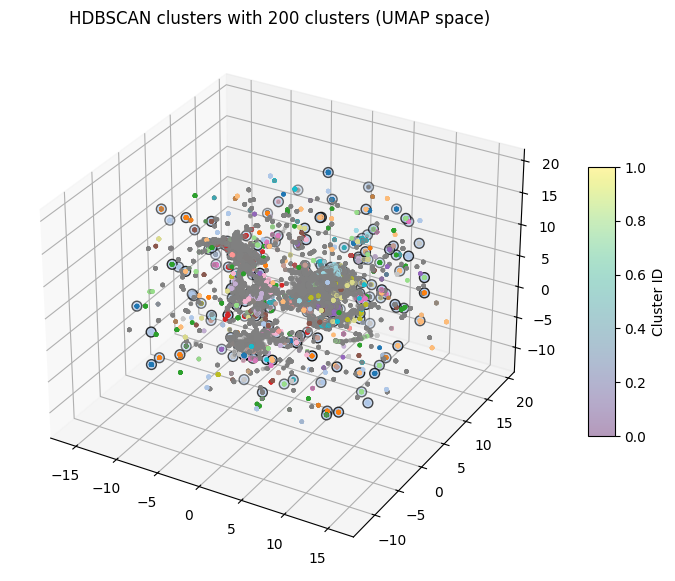

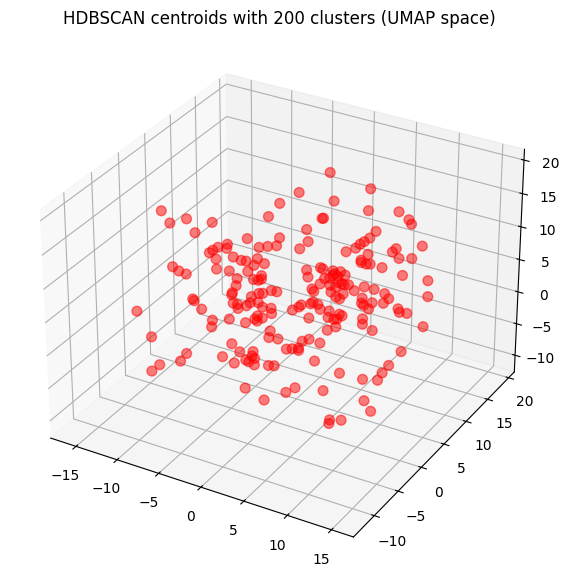

In [59]:
n_clusters_hdbscan = len(set(labels_hdbscan)) - (1 if -1 in labels_hdbscan else 0)  #Exclude noise (-1)

#Create a color palette for the clusters
colors = plt.cm.get_cmap("tab20", len(np.unique(labels_hdbscan)))  #Palette of distinct colors

#Visualize clusters with noise points in gray
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

#Cluster points
scatter_clusters = ax.scatter(
    projection[:, 0], projection[:, 1], projection[:, 2],
    c=[colors(label) if label != -1 else (0.5, 0.5, 0.5, 0.1) for label in labels_hdbscan],  #Noise in gray
    s=5, alpha=0.4
)

# Cluster centroids
ax.scatter(centroid_projected[:,0], centroid_projected[:,1], centroid_projected[:,2],
        c=[colors(i)], s=50, edgecolor='black', label=f'Centroid {i}', zorder = 3)


cbar = plt.colorbar(scatter_clusters, ax=ax, shrink=0.5, aspect=10)
cbar.set_label("Cluster ID")
plt.title(f"HDBSCAN clusters with {n_clusters_hdbscan} clusters (UMAP space)")

#Visualize centroids only
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    centroid_projected[:,0],
    centroid_projected[:,1],
    centroid_projected[:,2],
    c='red', s=50, alpha=0.5
)
plt.title(f"HDBSCAN centroids with {n_clusters_hdbscan} clusters (UMAP space)")
plt.show()


# Agglomerative clustering

Number of clusters: 20


/tmp/ipykernel_2642208/2393295693.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab20", len(np.unique(labels_agglo)))


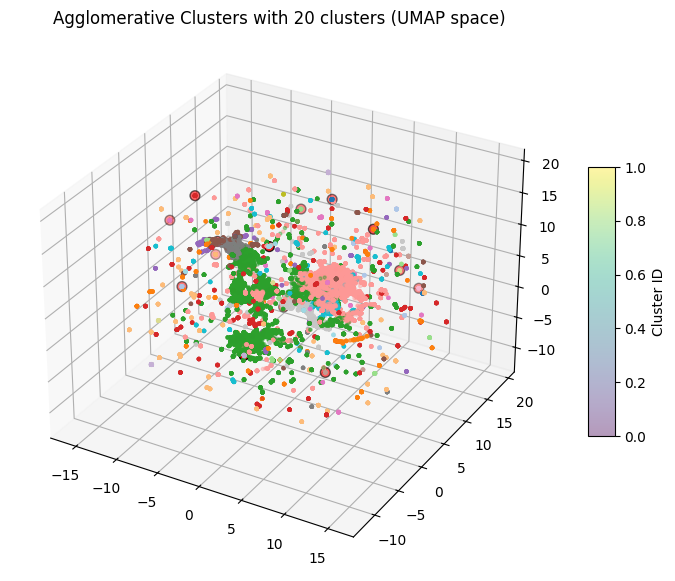

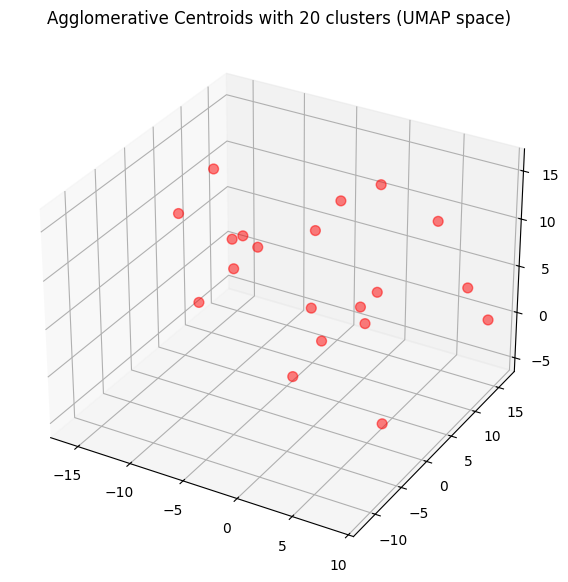

In [60]:
from sklearn.cluster import AgglomerativeClustering


#Agglomerative Clustering
agglo_clusterer = AgglomerativeClustering(n_clusters=20, metric="euclidean", linkage="ward")
labels_agglo = agglo_clusterer.fit_predict(mu_embeddings_normalized)

#Compute centroids
indices_centroids_agglo = []
centroids_agglo = []
unique_labels_agglo = set(labels_agglo)

for label in unique_labels_agglo:
    cluster_points = mu_embeddings_normalized[labels_agglo == label]
    cluster_indices = np.where(labels_agglo == label)[0]
    
    #Compute the median of the points in the cluster
    centroid = np.median(cluster_points, axis=0)
    centroids_agglo.append(centroid)
    
    #Find the index of the point closest to the centroid
    closest_point_idx = np.argmin(np.sum(np.abs(cluster_points - centroid), axis=1))
    indices_centroids_agglo.append(cluster_indices[closest_point_idx])  # Add the global index

centroids_agglo = np.array(centroids_agglo)
print(f"Number of clusters: {len(centroids_agglo)}")

#Project the centroids
centroid_projected = projection[indices_centroids_agglo]

n_clusters_agglo = len(unique_labels_agglo)

#Create a color palette for the clusters
colors = plt.cm.get_cmap("tab20", len(np.unique(labels_agglo)))

#Visualize clusters with points
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

#Cluster points
scatter_clusters = ax.scatter(
    projection[:, 0], projection[:, 1], projection[:, 2],
    c=[colors(label) for label in labels_agglo],
    s=5, alpha=0.4
)

#Cluster centroids
ax.scatter(
    centroid_projected[:, 0], centroid_projected[:, 1], centroid_projected[:, 2],
    c='red', s=50, edgecolor='black', label='Centroids', zorder=3
)

#Colorbar and title
cbar = plt.colorbar(scatter_clusters, ax=ax, shrink=0.5, aspect=10)
cbar.set_label("Cluster ID")
plt.title(f"Agglomerative Clusters with {n_clusters_agglo} clusters (UMAP space)")

#Visualize centroids only
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    centroid_projected[:, 0],
    centroid_projected[:, 1],
    centroid_projected[:, 2],
    c='red', s=50, alpha=0.5
)
plt.title(f"Agglomerative Centroids with {n_clusters_agglo} clusters (UMAP space)")
plt.show()



In [61]:
# Sihouette score Hierarchical Clustering
silhouette_avg = silhouette_score(mu_embeddings_normalized, labels_agglo)  # labels_agglo=labels Hierarchical Clustering
print("Silhouette Score (Hierarchical Clustering):", silhouette_avg)

Silhouette Score (Hierarchical Clustering): 0.19092572


/tmp/ipykernel_2642208/1004607898.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(centroids_hierarchical_projected_PCA_2D[i, 0], centroids_hierarchical_projected_PCA_2D[i, 1],


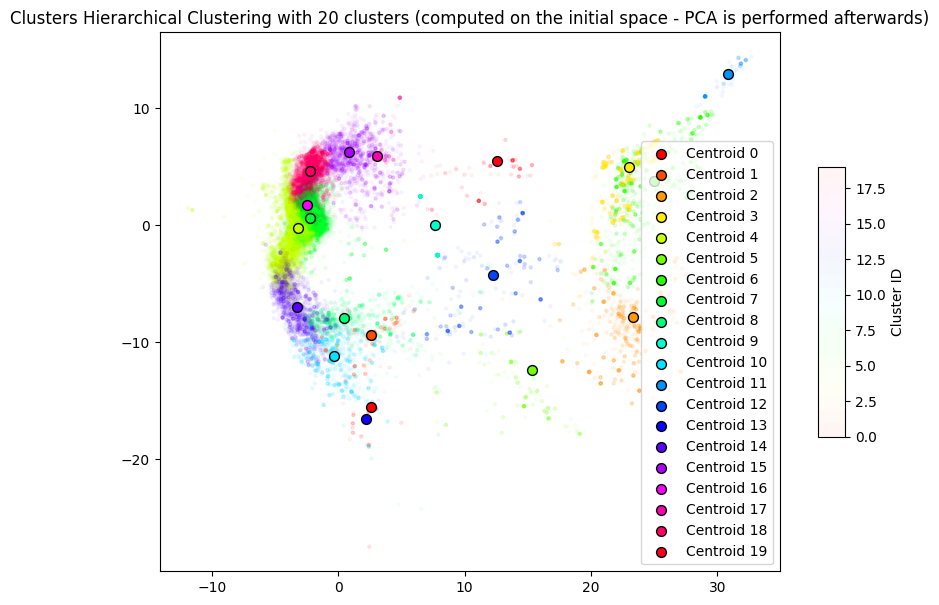

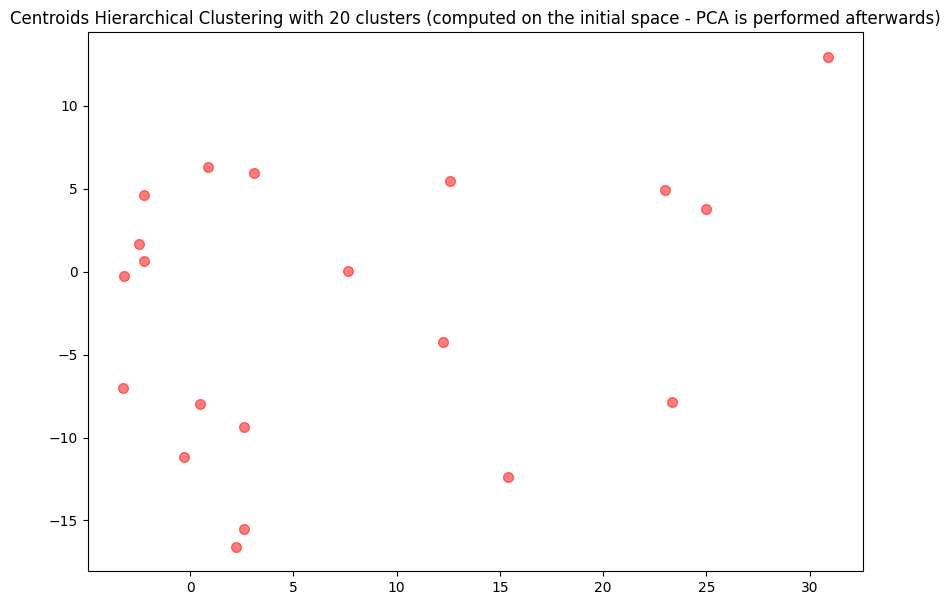

/tmp/ipykernel_2642208/1004607898.py:37: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(centroids_hierarchical_projected_PCA_2D[i, 0], centroids_hierarchical_projected_PCA_2D[i, 1],


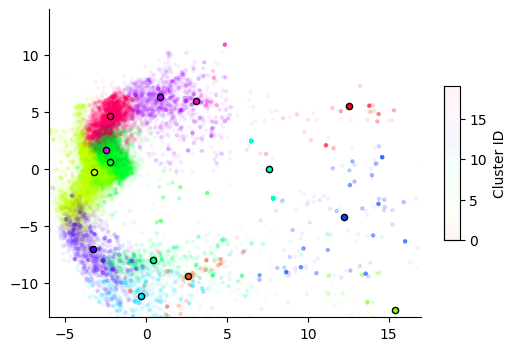

In [62]:
#Extraction of centroids from the clusters of Hierarchical Clustering
centroids_hierarchical_projected_PCA_2D = pca_projection_2d[indices_centroids_agglo]

#Definition of colors for the clusters
colors_2D = custom_cmap.colors if hasattr(custom_cmap, "colors") else plt.cm.hsv(np.linspace(0, 1, n_clusters))

#Visualization of clusters and centroids
fig, ax = plt.subplots(figsize=(10, 7))

scatter_clusters = ax.scatter(pca_projection_2d[:, 0], pca_projection_2d[:, 1], 
                               c=labels_agglo, s=5, cmap=custom_cmap, alpha=0.04)
for i in range(n_clusters_agglo):
    ax.scatter(centroids_hierarchical_projected_PCA_2D[i, 0], centroids_hierarchical_projected_PCA_2D[i, 1],
               c=colors_2D[i], s=50, edgecolor='black', label=f'Centroid {i}')

cbar = plt.colorbar(scatter_clusters, ax=ax, shrink=0.5, aspect=10)
cbar.set_label("Cluster ID")
plt.title(f"Clusters Hierarchical Clustering with {n_clusters_agglo} clusters (computed on the initial space - PCA is performed afterwards)")

#Display
plt.legend()
plt.show()

#Visualization of centroids only
fig, ax = plt.subplots(figsize=(10, 7))
scatter = ax.scatter(centroids_hierarchical_projected_PCA_2D[:, 0], 
                      centroids_hierarchical_projected_PCA_2D[:, 1], 
                      c='red', s=50, alpha=0.5)
plt.title(f"Centroids Hierarchical Clustering with {n_clusters_agglo} clusters (computed on the initial space - PCA is performed afterwards)")
plt.show()

#Zoom on clusters in PCA 2D with adjusted limits
fig, ax = plt.subplots(figsize=(6, 4))
scatter_clusters = ax.scatter(pca_projection_2d[:, 0], pca_projection_2d[:, 1], 
                               c=labels_agglo, s=5, cmap=custom_cmap, alpha=0.04)
for i in range(n_clusters_agglo):
    ax.scatter(centroids_hierarchical_projected_PCA_2D[i, 0], centroids_hierarchical_projected_PCA_2D[i, 1],
               c=colors_2D[i], s=20, edgecolor='black', label=f'Centroid {i}')

ax.set_xlim(-6, 17)
ax.set_ylim(-13, 14)

cbar = plt.colorbar(scatter_clusters, ax=ax, shrink=0.5, aspect=10)
cbar.set_label("Cluster ID")

#Removal of unnecessary frames
sns.despine()
plt.show()




/tmp/ipykernel_2642208/2758685453.py:15: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(


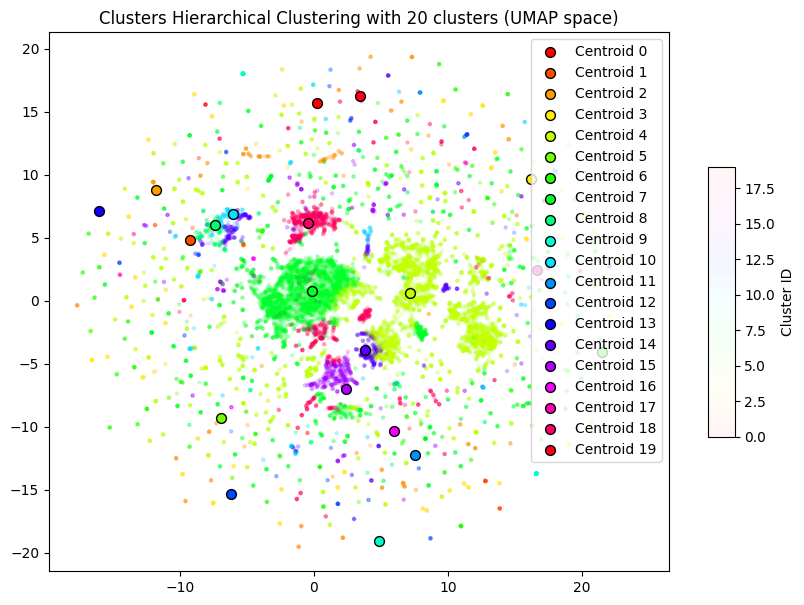

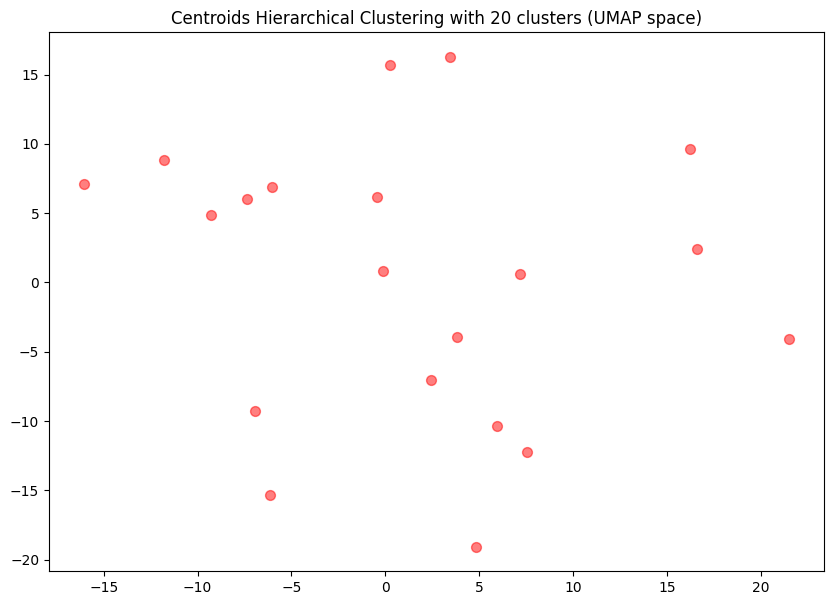

/tmp/ipykernel_2642208/2758685453.py:43: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(


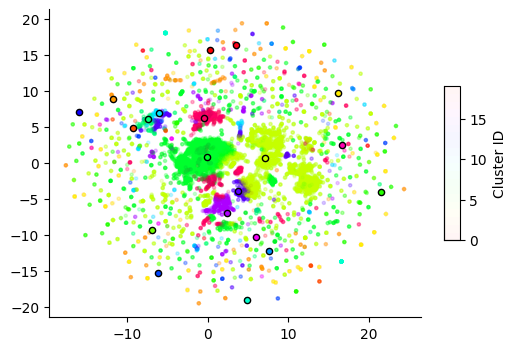

In [63]:
#Project the centroids of Hierarchical Clustering into the UMAP 2D space
centroids_hierarchical_projected_2D = projection_2D[indices_centroids_agglo]

#Definition of colors for the clusters
colors_2D = custom_cmap.colors if hasattr(custom_cmap, "colors") else plt.cm.hsv(np.linspace(0, 1, n_clusters_agglo))

#Visualization of clusters and centroids
fig, ax = plt.subplots(figsize=(10, 7))

scatter_clusters = ax.scatter(
    projection_2D[:, 0], projection_2D[:, 1], 
    c=labels_agglo, s=5, cmap=custom_cmap, alpha=0.04
)
for i in range(n_clusters_agglo):
    ax.scatter(
        centroids_hierarchical_projected_2D[i, 0], centroids_hierarchical_projected_2D[i, 1], 
        c=colors_2D[i], s=50, edgecolor='black', label=f'Centroid {i}'
    )

cbar = plt.colorbar(scatter_clusters, ax=ax, shrink=0.5, aspect=10)
cbar.set_label("Cluster ID")
plt.title(f"Clusters Hierarchical Clustering with {n_clusters_agglo} clusters (UMAP space)")
plt.legend()
plt.show()

#Visualization of centroids only
fig, ax = plt.subplots(figsize=(10, 7))
scatter = ax.scatter(
    centroids_hierarchical_projected_2D[:, 0], centroids_hierarchical_projected_2D[:, 1], 
    c='red', s=50, alpha=0.5
)
plt.title(f"Centroids Hierarchical Clustering with {n_clusters_agglo} clusters (UMAP space)")
plt.show()

#Zoom on clusters in UMAP 2D with adjusted limits
fig, ax = plt.subplots(figsize=(6, 4))

scatter_clusters = ax.scatter(
    projection_2D[:, 0], projection_2D[:, 1], 
    c=labels_agglo, s=5, cmap=custom_cmap, alpha=0.04
)
for i in range(n_clusters_agglo):
    ax.scatter(
        centroids_hierarchical_projected_2D[i, 0], centroids_hierarchical_projected_2D[i, 1], 
        c=colors_2D[i], s=20, edgecolor='black', label=f'Centroid {i}'
    )

cbar = plt.colorbar(scatter_clusters, ax=ax, shrink=0.5, aspect=10)
cbar.set_label("Cluster ID")
sns.despine()
plt.show()
